# Data Augmentation Analysis for Bruise Detection

This notebook compares different data augmentation strategies:
1. Baseline (no augmentation)
2. Horizontal flip only
3. Rotation only (±20 degrees)
4. Zoom only (±20%)
5. All augmentations combined

We'll use the same model architecture and preprocessing from the main CNN notebook.

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import pandas as pd

In [50]:
def load_binary_data(data_dir='dataset/Wound_dataset copy', img_size=(224, 224)):
    images = []
    labels = []
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        raise ValueError(f"Dataset directory not found: {data_dir}")
    
    # Process bruise images (positive class)
    bruise_path = os.path.join(data_dir, 'Bruises')
    if not os.path.exists(bruise_path):
        raise ValueError(f"Bruises directory not found: {bruise_path}")
    
    for img_name in os.listdir(bruise_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(bruise_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(1)  # 1 for bruise
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    # Process normal skin images (negative class)
    normal_path = os.path.join(data_dir, 'Normal')
    if not os.path.exists(normal_path):
        raise ValueError(f"Normal directory not found: {normal_path}")
    
    for img_name in os.listdir(normal_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(normal_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(0)  # 0 for normal
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    if not images:
        raise ValueError("No images were loaded. Check the dataset structure and file formats.")
    
    return np.array(images), np.array(labels)

# Try loading the dataset with explicit error handling
try:
    print("Attempting to load dataset...")
    print("Current working directory:", os.getcwd())
    X, y = load_binary_data()
    print("Dataset shape:", X.shape)
    print("Number of bruise images:", np.sum(y == 1))
    print("Number of normal images:", np.sum(y == 0))
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please verify the dataset path and structure.")

Attempting to load dataset...
Current working directory: C:\Users\Rodney Lei Estrada\xcode\bruise_detection_project
Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200
Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200


## Visualization of Data Augmentation
- Flip
- Rotate
- Zoom
- All

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def show_augmentation_examples(X, augmentation_config=None, num_samples=5):
    # Create data generator with augmentation
    if augmentation_config is not None:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            **augmentation_config
        )
    else:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    # Select a random image and expand dimensions to fit the generator input
    idx = np.random.randint(0, len(X))
    sample_image = X[idx]
    sample_image_batch = np.expand_dims(sample_image, axis=0)

    # Generate augmented images
    augmented_images = [next(datagen.flow(sample_image_batch, batch_size=1))[0] for _ in range(num_samples)]

    # Plot original vs augmented
    plt.figure(figsize=(18, 6))
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(sample_image)
    plt.title("Original")
    plt.axis('off')

    for i, aug_image in enumerate(augmented_images):
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(aug_image)
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

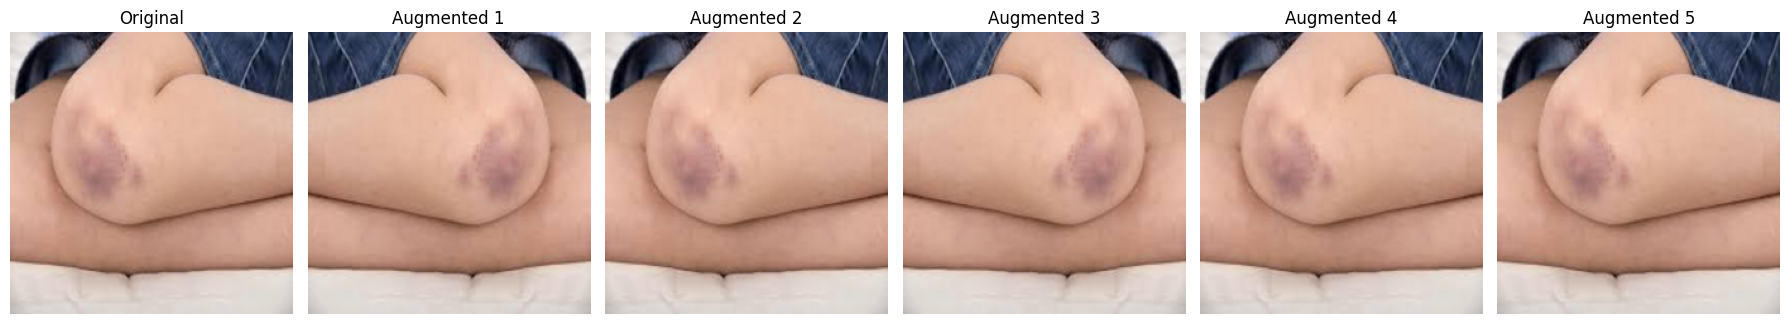

In [61]:
show_augmentation_examples(X_train, augmentation_configs['flip'], num_samples=5)

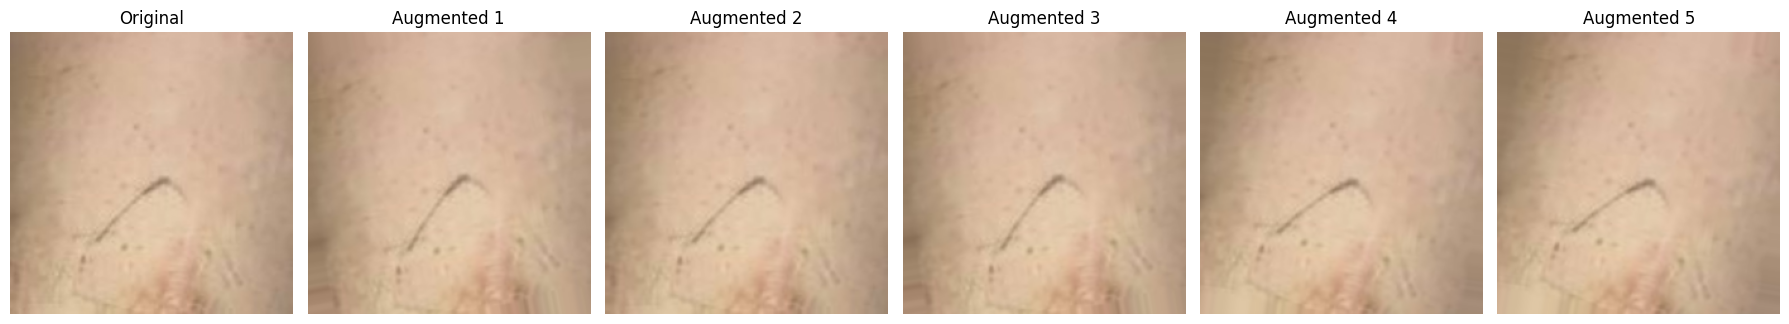

In [62]:
show_augmentation_examples(X_train, augmentation_configs['rotation'], num_samples=5)

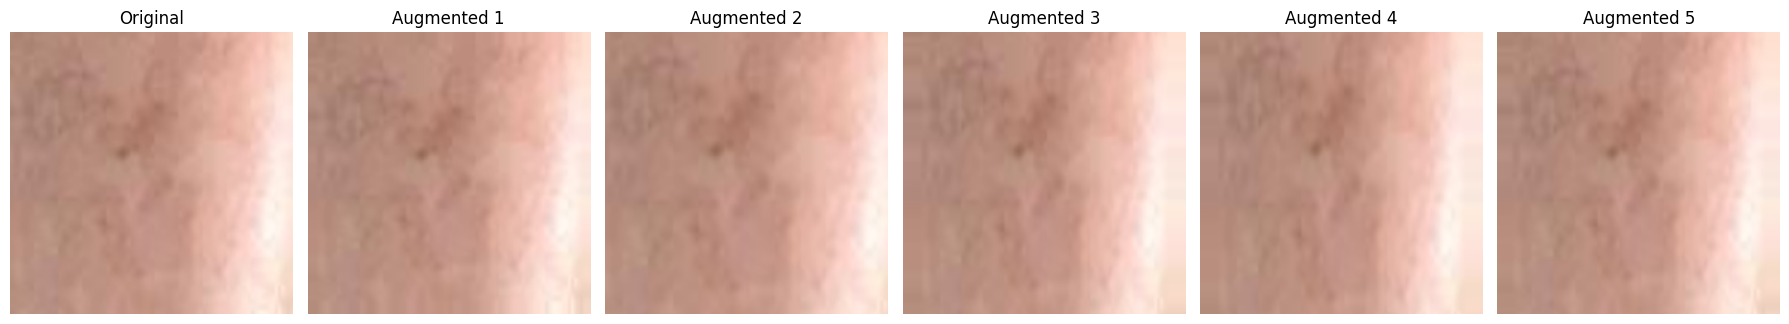

In [63]:
show_augmentation_examples(X_train, augmentation_configs['zoom'], num_samples=5)

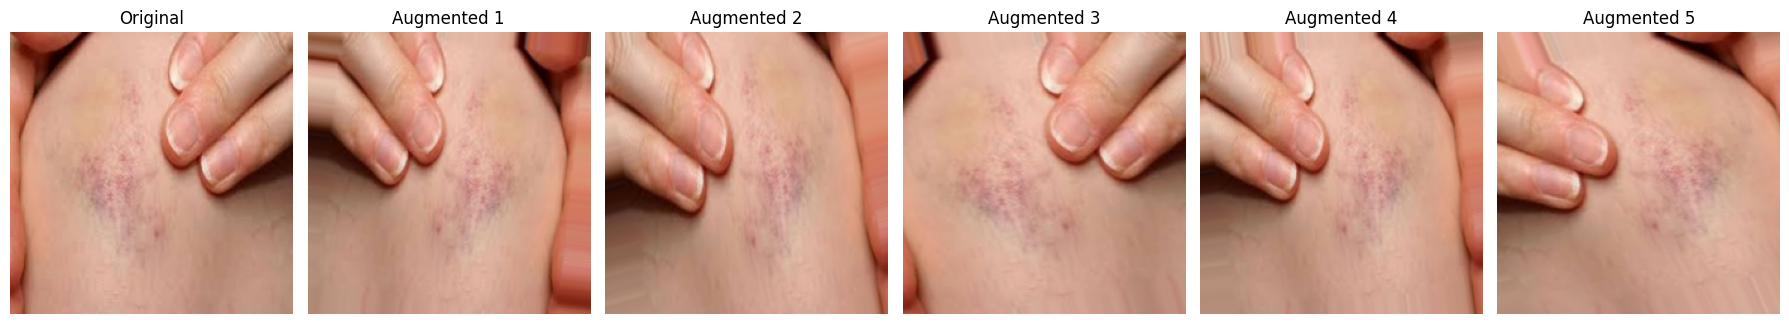

In [64]:
show_augmentation_examples(X_train, augmentation_configs['all'], num_samples=5)

## Model Architecture and Training Functions

We'll use the same CNN architecture as the main notebook, but train it with different augmentation strategies.

In [51]:
def create_model(input_shape):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Simple CNN architecture
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense layer
        layers.Dense(64, activation='relu'),
        
        # Output layer (binary classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def train_model_with_augmentation(X_train, y_train, X_val, y_val, augmentation_config=None, model_name="baseline"):
    # Create data generator with augmentation
    if augmentation_config is not None:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            **augmentation_config
        )
    else:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    # Create and compile model
    input_shape = X_train[0].shape
    model = create_model(input_shape)
    
    # Define custom metrics
    precision_metric = tf.keras.metrics.Precision(name='precision')
    recall_metric = tf.keras.metrics.Recall(name='recall')
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', precision_metric, recall_metric]
    )
    
    # Train the model with custom callbacks
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=32),
        epochs=10,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ],
        verbose=1
    )
    
    return model, history

# Define augmentation configurations
augmentation_configs = {
    'baseline': None,
    'flip': {'horizontal_flip': True},
    'rotation': {'rotation_range': 20},
    'zoom': {'zoom_range': 0.2},
    'all': {
        'horizontal_flip': True,
        'rotation_range': 20,  
        'zoom_range': 0.2    
    }
}

# Split data only if X and y are not empty
if X.size == 0 or y.size == 0:
    print("Warning: X and/or y are empty. Please check your dataset loading step.")
    X_train = X_val = X_test = y_train = y_val = y_test = np.array([])
else:
    # First split off test set (10%)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Split remaining 90% into train (70%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

    print("\nData split sizes:")
    print(f"Training set: {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
    print(f"Test set: {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")


Data split sizes:
Training set: 317 images (71.7%)
Validation set: 80 images (18.1%)
Test set: 45 images (10.2%)


## Train Models with Different Augmentation Strategies

We'll train 5 different models and compare their performance:

In [ ]:
# Dictionary to store results
results = {}

# Train models with different augmentation strategies
for aug_name, aug_config in augmentation_configs.items():
    print(f"\nTraining model with {aug_name} augmentation...")
    model, history = train_model_with_augmentation(
        X_train, y_train,
        X_val, y_val,
        augmentation_config=aug_config,
        model_name=aug_name
    )
    
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
    
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    results[aug_name] = {
        'model': model,  
        'history': history.history,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }
    
    print(f"\nTest Results for {aug_name}:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Training model with baseline augmentation...


C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5296 - loss: 7.7276 - precision: 0.5384 - recall: 0.6056 - val_accuracy: 0.7250 - val_loss: 0.5182 - val_precision: 0.9583 - val_recall: 0.5227
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5296 - loss: 7.7276 - precision: 0.5384 - recall: 0.6056 - val_accuracy: 0.7250 - val_loss: 0.5182 - val_precision: 0.9583 - val_recall: 0.5227
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8035 - loss: 0.4171 - precision: 0.9292 - recall: 0.6937 - val_accuracy: 0.8750 - val_loss: 0.3829 - val_precision: 0.8542 - val_recall: 0.9318
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8035 - loss: 0.4171 - precision: 0.9292 - recall: 0.6937 - val_accuracy: 0.8750 - val_loss: 0.3829 - val_precision: 0.8542 - val_recall: 0.9318
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 938ms/step - accuracy: 0.8758 - loss: 0.3506 - precision: 0.8900 - recall: 0.8887 - val_accuracy: 0.8125 - val_loss: 0.4127 - v

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5344 - loss: 8.2338 - precision: 0.5270 - recall: 0.6336 - val_accuracy: 0.4625 - val_loss: 1.3982 - val_precision: 1.0000 - val_recall: 0.0227
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5344 - loss: 8.2338 - precision: 0.5270 - recall: 0.6336 - val_accuracy: 0.4625 - val_loss: 1.3982 - val_precision: 1.0000 - val_recall: 0.0227
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6100 - loss: 0.8789 - precision: 0.6711 - recall: 0.5493 - val_accuracy: 0.8250 - val_loss: 0.4125 - val_precision: 0.9167 - val_recall: 0.7500
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6100 - loss: 0.8789 - precision: 0.6711 - recall: 0.5493 - val_accuracy: 0.8250 - val_loss: 0.4125 - val_precision: 0.9167 - val_recall: 0.7500
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8713 - loss: 0.4305 - precision: 0.9243 - recall: 0.8445 - val_accuracy: 0.7875 - val_loss: 0.4339 - val

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4816 - loss: 14.3053 - precision: 0.5405 - recall: 0.6255 - val_accuracy: 0.6500 - val_loss: 1.5469 - val_precision: 0.6212 - val_recall: 0.9318
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4816 - loss: 14.3053 - precision: 0.5405 - recall: 0.6255 - val_accuracy: 0.6500 - val_loss: 1.5469 - val_precision: 0.6212 - val_recall: 0.9318
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7275 - loss: 1.2642 - precision: 0.7697 - recall: 0.7614 - val_accuracy: 0.8125 - val_loss: 0.9340 - val_precision: 1.0000 - val_recall: 0.6591
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7275 - loss: 1.2642 - precision: 0.7697 - recall: 0.7614 - val_accuracy: 0.8125 - val_loss: 0.9340 - val_precision: 1.0000 - val_recall: 0.6591
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8289 - loss: 0.5147 - precision: 0.8558 - recall: 0.8430 - val_accuracy: 0.8875 - val_loss: 0.3470 - v

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5079 - loss: 10.6822 - precision: 0.4960 - recall: 0.5062 - val_accuracy: 0.4500 - val_loss: 1.1514 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5079 - loss: 10.6822 - precision: 0.4960 - recall: 0.5062 - val_accuracy: 0.4500 - val_loss: 1.1514 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6580 - loss: 0.6805 - precision: 0.6110 - recall: 0.6309 - val_accuracy: 0.8000 - val_loss: 0.5131 - val_precision: 0.7593 - val_recall: 0.9318
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6580 - loss: 0.6805 - precision: 0.6110 - recall: 0.6309 - val_accuracy: 0.8000 - val_loss: 0.5131 - val_precision: 0.7593 - val_recall: 0.9318
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7075 - loss: 0.5852 - precision: 0.7240 - recall: 0.7224 - val_accuracy: 0.8875 - val_

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4666 - loss: 14.7436 - precision: 0.5132 - recall: 0.3224 - val_accuracy: 0.5500 - val_loss: 0.8192 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4666 - loss: 14.7436 - precision: 0.5132 - recall: 0.3224 - val_accuracy: 0.5500 - val_loss: 0.8192 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5566 - loss: 0.7219 - precision: 0.5610 - recall: 0.9548 - val_accuracy: 0.8250 - val_loss: 0.6401 - val_precision: 0.9167 - val_recall: 0.7500
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5566 - loss: 0.7219 - precision: 0.5610 - recall: 0.9548 - val_accuracy: 0.8250 - val_loss: 0.6401 - val_precision: 0.9167 - val_recall: 0.7500
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7510 - loss: 0.6019 - precision: 0.7517 - recall: 0.8694 - val_accuracy: 0.7125 - val_loss: 0.6089 - v

## Visualization and Analysis

In [66]:
def plot_training_histories(results):
    plt.figure(figsize=(15, 10))
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    
    # Define color pairs for each augmentation (main color, lighter variant)
    colors = {
        'baseline': ('#000000', '#666666'),  # Black, Gray
        'flip': ('#1f77b4', '#7fb4e4'),      # Dark blue, Light blue
        'rotation': ('#2ca02c', '#7dce7d'),   # Dark green, Light green
        'zoom': ('#d62728', '#ff7f7f'),      # Dark red, Light red
        'all': ('#9467bd', '#c7a7ed')        # Dark purple, Light purple
    }
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        has_data = False
        
        for aug_name in results.keys():
            history = results[aug_name]['history']
            if metric in history:
                values = history[metric]
                main_color, val_color = colors[aug_name]
                
                # Plot training line
                line = plt.plot(values, color=main_color, linestyle='-', 
                              linewidth=2, label=f'{aug_name}')[0]
                
                has_data = True
                if f'val_{metric}' in history:
                    val_values = history[f'val_{metric}']
                    # Plot validation line
                    val_line = plt.plot(val_values, color=val_color, linestyle='--', 
                                      linewidth=2, label=f'{aug_name} val')[0]
        
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        if has_data:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_performance_comparison(results):
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'roc_auc']
    labels = [m.replace('test_', '').capitalize() for m in metrics]
    x = np.arange(len(results))
    width = 0.8 / len(metrics)
    
    # Define distinct colors for each metric
    colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']  # Blue, Green, Red, Purple
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, (metric, label) in enumerate(zip(metrics, labels)):
        values = []
        for aug_name in results.keys():
            value = results[aug_name].get(metric, 0)
            value = 0 if np.isnan(value) else value
            values.append(value)
        bars = ax.bar(x + i*width - width*len(metrics)/2, values, width, 
                     label=label, color=colors[i])
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom')
    
    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison Across Augmentation Strategies')
    ax.set_xticks(x)
    ax.set_xticklabels(list(results.keys()), rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Detailed Metrics Comparison

Let's analyze the performance metrics in tabular format:

Performance Metrics:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,baseline,88.89%,91.30%,87.50%,89.36%,95.83%
1,flip,88.89%,95.24%,83.33%,88.89%,97.22%
2,rotation,93.33%,95.65%,91.67%,93.62%,98.81%
3,zoom,82.22%,86.36%,79.17%,82.61%,93.85%
4,all,64.44%,60.53%,95.83%,74.19%,84.72%


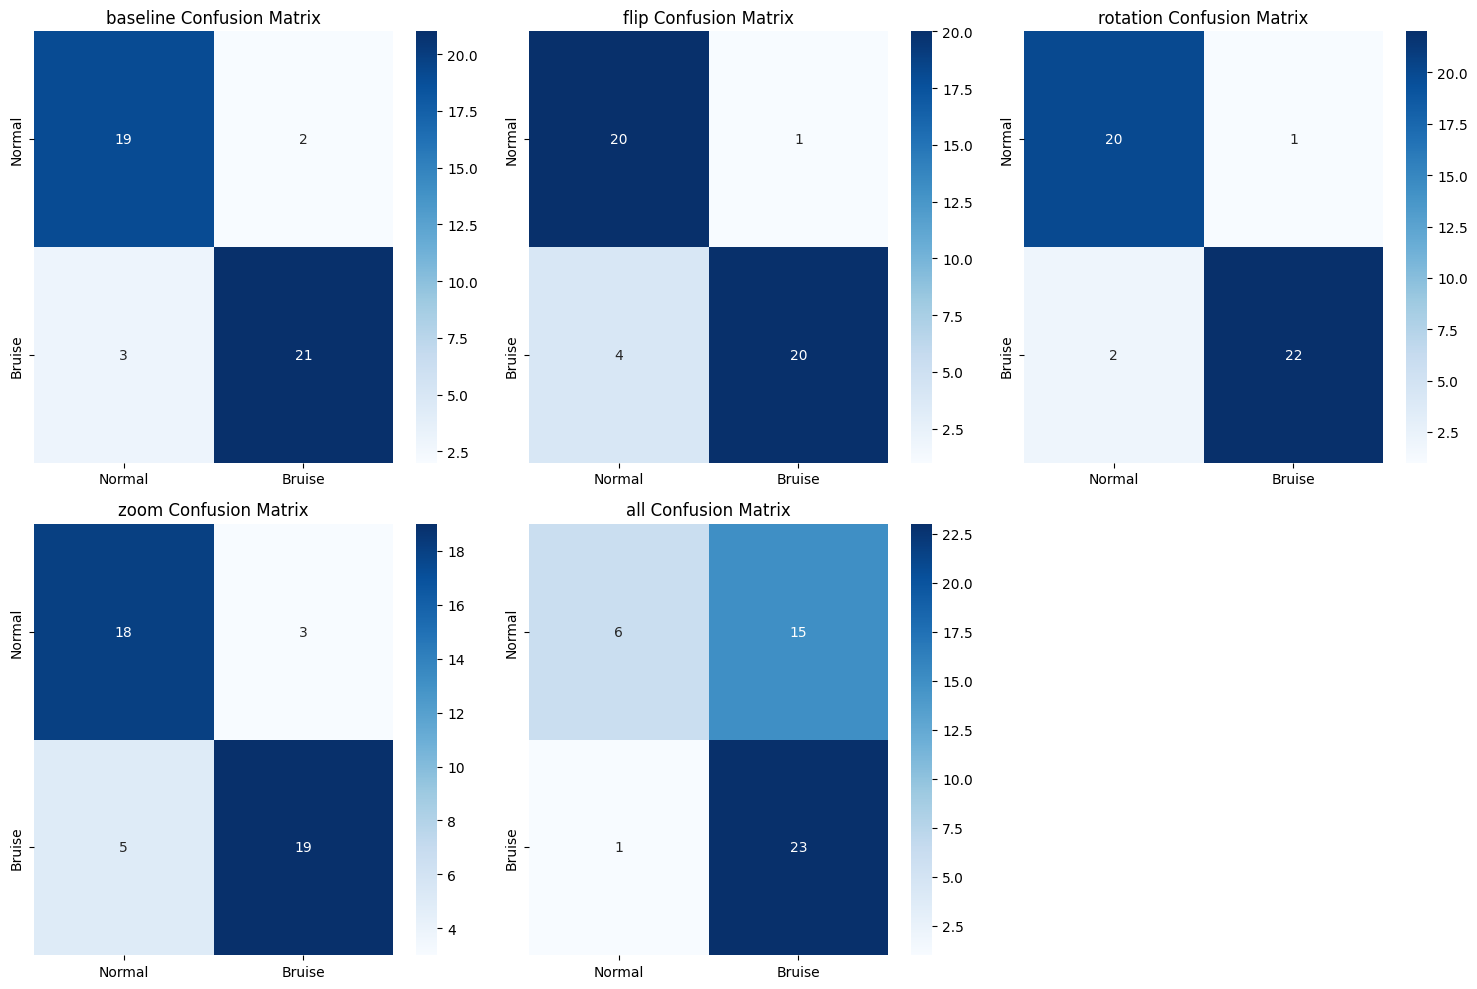

In [67]:
def create_metrics_tables_and_plots(results):
    # Create detailed metrics dataframe
    metrics_data = []
    
    for model_name in results.keys():
        result = results[model_name]
        precision = result.get('test_precision', 0)
        recall = result.get('test_recall', 0)
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_data.append({
            'Model': model_name,
            'Accuracy': result.get('test_accuracy', 0),
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'ROC AUC': result.get('roc_auc', 0)
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Format percentages
    for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']:
        metrics_df[col] = metrics_df[col].apply(lambda x: f"{x*100:.2f}%")
    
    # Print metrics table
    print("Performance Metrics:")
    display(metrics_df)
    
    # Plot confusion matrices
    n_models = len(results)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (model_name, result) in enumerate(results.items()):
        if idx < len(axes) and 'confusion_matrix' in result:
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Normal', 'Bruise'],
                       yticklabels=['Normal', 'Bruise'],
                       ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
    
    # Remove empty subplots
    for idx in range(n_models, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Generate the detailed analysis
create_metrics_tables_and_plots(results)


Generating visualizations and analysis...

Plotting training histories...


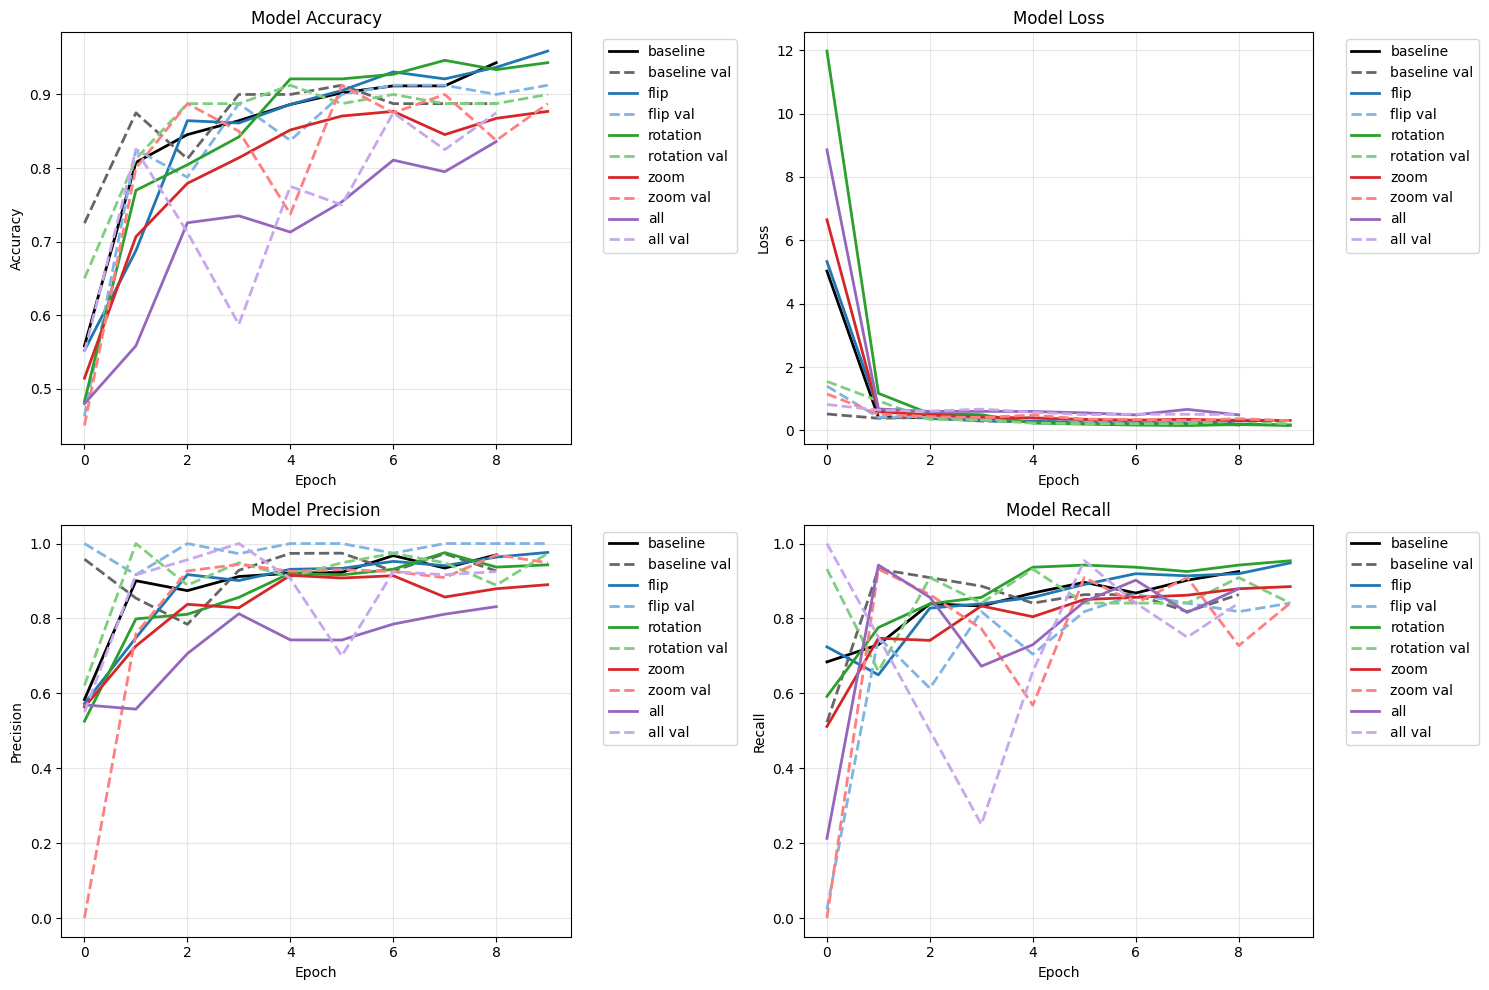


Plotting performance comparison...


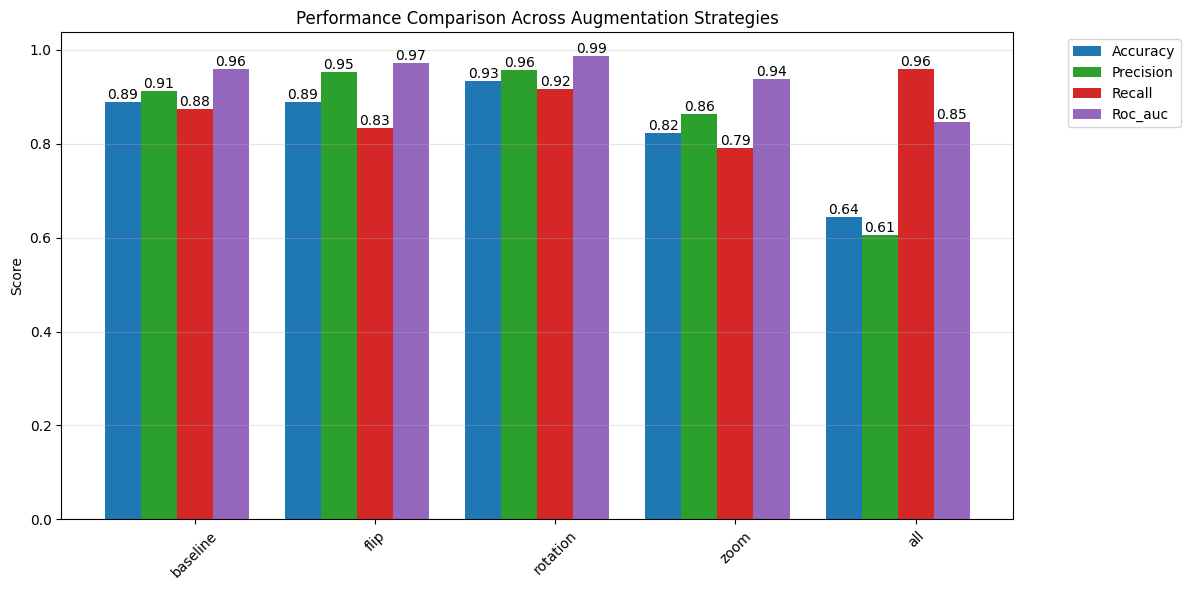


Generating detailed metrics and confusion matrices...
Performance Metrics:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,baseline,88.89%,91.30%,87.50%,89.36%,95.83%
1,flip,88.89%,95.24%,83.33%,88.89%,97.22%
2,rotation,93.33%,95.65%,91.67%,93.62%,98.81%
3,zoom,82.22%,86.36%,79.17%,82.61%,93.85%
4,all,64.44%,60.53%,95.83%,74.19%,84.72%


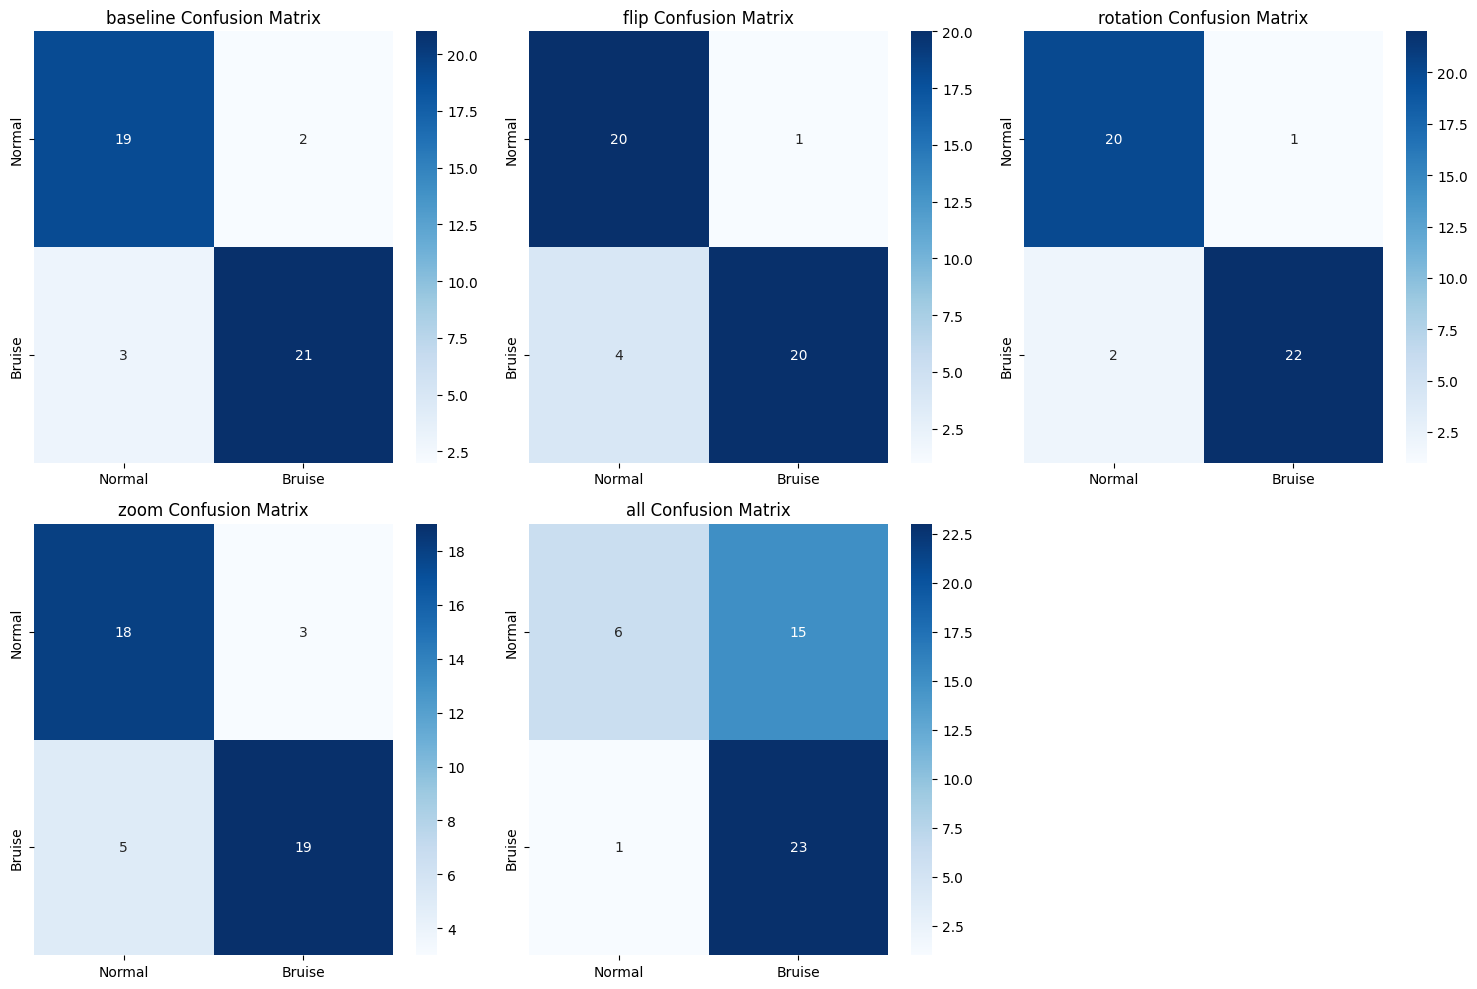

In [69]:
print("\nGenerating visualizations and analysis...")

print("\nPlotting training histories...")
plot_training_histories(results)

print("\nPlotting performance comparison...")
plot_performance_comparison(results)

print("\nGenerating detailed metrics and confusion matrices...")
create_metrics_tables_and_plots(results)

